In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


#from keras.layers import Dense, Input
#from keras.models import Model

#import omnifold6b as of

#import tensorflow as tf

#import simple_pdf2b as simple_pdf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
#print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]






#--- perfect
#resolution = [ 0.000001  ]

#--- very good
#resolution = [ 0.05  ]

#--- good
#resolution = [ 0.25  ]

#--- nominal
resolution = [ 0.5  ]

#--- medium poor
#resolution = [ 0.75  ]

#--- poor
#resolution = [ 1.0  ]







train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






#ngen_train = 100000
#ngen_true =   10000

ngen_train = 1000000
ngen_true =   100000

of_niter = 5





do_bootstrap = False

n_boot_samples = 500



ds_input_dir = 'toy-study8b-inspect-of-1d-2d-100k-10k-nominal'
#ds_input_dir = 'toy-study8b-inspect-of-1d-2d-4M-400k-nominal'
#ds_input_dir = 'toy-study8b-inspect-of-1d-2d-100k-10k-perfect'

read_samples = True

output_dir = 'hist-pdf-toy-study-1d-2a-inspect-of'

#save_step2_model = True



hist_low = -10.
hist_high = 10.

hist_nbins = 1000


hist_binwidth = (hist_high - hist_low) / hist_nbins




############window_dx = 0.3

window_dx = 0.3






window_nbins = int( window_dx / hist_binwidth )

print(' window_nbins : %d' % window_nbins)

hist_pars = {}
hist_pars['low']  = hist_low
hist_pars['high'] = hist_high
hist_pars['nbins'] = hist_nbins
hist_pars['binwidth'] = hist_binwidth
hist_pars['window_dx'] = window_dx
hist_pars['window_nbins'] = window_nbins






 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100
 window_nbins : 15


In [4]:
hist_pars

{'low': -10.0,
 'high': 10.0,
 'nbins': 1000,
 'binwidth': 0.02,
 'window_dx': 0.3,
 'window_nbins': 15}

In [5]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()



 Output directory already exists:  hist-pdf-toy-study-1d-2a-inspect-of


In [6]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [7]:
train_cov_inv = np.linalg.inv( train_cov )

In [8]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [9]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [10]:
true_cov_inv = np.linalg.inv( true_cov )

In [11]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [12]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [13]:

#--- Read the datasets instead of generating new ones.



if read_samples :


    with open('%s/train-and-true-samples.npy' % ds_input_dir, 'rb') as f :
        train_pts = np.load(f)
        train_det_pts = np.load(f)
        true_pts = np.load(f)
        true_det_pts = np.load(f)

    ngen_train = len(train_pts)    
    ngen_true = len(true_pts)

    with open( '%s/config-pars.npy' % output_dir , 'rb' ) as f :
        train_mu = np.load(f)
        train_rho = np.load(f)
        train_sig = np.load(f)
        true_mu = np.load(f)
        true_rho = np.load(f)
        true_sig = np.load(f)
        resolution = np.load(f)
        train_cov = np.load(f)
        true_cov = np.load(f)

else :

    train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
    true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
    train_det_pts = np.random.normal( train_pts, resolution )
    true_det_pts = np.random.normal( true_pts, resolution )
    
    
print('\n\n train_pts:')
print( train_pts )
print('\n\n')
print(' train_pts shape:  %s' % str(train_pts.shape))

train_both = np.stack([train_pts, train_det_pts], axis=1)
    
#-- ok to regenerate these (just for plots)
true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights




 train_pts:
[[ 0.4106739 ]
 [-0.81553319]
 [-0.85333993]
 ...
 [-0.3707894 ]
 [ 1.00340217]
 [-0.88310205]]



 train_pts shape:  (100000, 1)


In [14]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [15]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [16]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )



config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : hist-pdf-toy-study-1d-2a-inspect-of/config.txt

2024-07-15 13:52:31.792011

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1


train_mu : [0.]
train_rho : [[0.]]
train_sig : [1.]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.5]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

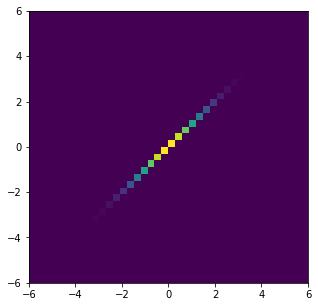

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

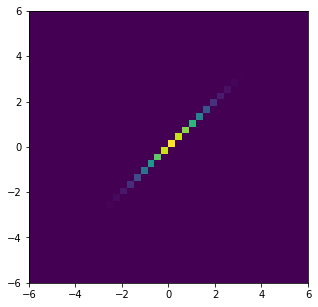

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

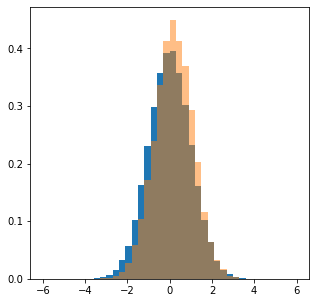

In [19]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [20]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[ 0.4106739 ]
 [-0.81553319]
 [-0.85333993]
 ...
 [-0.3707894 ]
 [ 1.00340217]
 [-0.88310205]]


In [21]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[ 0.2106739 ]
 [-1.01553319]
 [-1.05333993]
 ...
 [-0.5707894 ]
 [ 0.80340217]
 [-1.08310205]]


In [22]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [23]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [24]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [25]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [26]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [27]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [28]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [29]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [30]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.51856418 0.40457743 0.39201332 ... 0.52670886 0.34103407 0.38201341]


In [31]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.60993576 0.33167023 0.31603687 ... 0.51267361 0.42086908 0.30387269]


In [32]:
pdf_ratio = pdf_true / pdf_train

In [33]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [34]:
calc_weight = pdf_ratio

In [35]:
calc_weight_scaled = sample_sf * pdf_ratio

In [36]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

## Define function for calculating model pars (mean and cov) from weighted events

In [37]:
def calc_mean_cov( weights, fi1, fi2, sample_points ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * sample_points[:,fi1] )
    wx2 = np.sum( weights * sample_points[:,fi2] )
    wx1x2 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi1] )
        wx2x2 = np.sum( weights * sample_points[:,fi2] * sample_points[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [38]:
weights_true = np.ones( ngen_true )

In [39]:
true_calc_mean = np.zeros( ndim )
true_calc_cov = np.ones( shape=(ndim,ndim) )

In [40]:
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        rd = calc_mean_cov( weights_true, fi1, fi2, true_pts )
        true_calc_mean[fi1] = rd['mean_x1']
        true_calc_cov[fi1,fi2] = rd['cov_x1x2']

In [41]:
for fi1 in range(ndim) :
    print('  mean f%d :  %7.3f' % (fi1, true_calc_mean[fi1]))
    for fi2 in range(fi1,ndim) :
        print('  cov f%df%d :  %7.4f' % (fi1,fi2, true_calc_cov[fi1,fi2]))
        if fi1 == fi2 :
            print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(true_calc_cov[fi1,fi1])))
        

  mean f0 :    0.202
  cov f0f0 :   0.8139
  sigma f0 :   0.9021


In [42]:
print( true_pts.shape )
print( true_pts.shape[1])

(10000, 1)
1


In [43]:
def calc_model_pars( weights, sample_points, verbose=0 ) :
    
    return_dict = {}
    
    ndim = sample_points.shape[1]
    if verbose : print(' ndim = %d' % ndim )
    
    model_mean = np.zeros( ndim )
    model_cov = np.ones( shape=(ndim,ndim) )
    
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            rd = calc_mean_cov( weights, fi1, fi2, sample_points )
            model_mean[fi1] = rd['mean_x1']
            model_cov[fi1,fi2] = rd['cov_x1x2']    
            if verbose and fi2==fi1 : print('  mean f%d :  %7.3f' % (fi1, model_mean[fi1]))
            if verbose : print('  cov f%df%d :  %7.4f' % (fi1,fi2, model_cov[fi1,fi2]))
            if verbose and fi2==fi1 : print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(model_cov[fi1,fi1])))
   
    for fi2 in range(ndim) :
        for fi1 in range(fi2+1,ndim) :
            model_cov[fi1,fi2] = model_cov[fi2,fi1]
    
    return_dict['mean'] = model_mean
    return_dict['cov']  = model_cov
    
    return return_dict


In [44]:
test_calc_true_model = calc_model_pars( weights_true, true_pts, 1)

 ndim = 1
  mean f0 :    0.202
  cov f0f0 :   0.8139
  sigma f0 :   0.9021


In [45]:
test_calc_true_model

{'mean': array([0.20184146]), 'cov': array([[0.81385781]])}

## Define function to calculate the reweighting factor (pdf2/pdf1).

In [46]:
def calc_pdf_ratio( model1_mu, model2_mu, model1_cov, model2_cov, sample_points ) :
    
    ndim = len(model1_mu)
    
    pts_minus_mu1 = sample_points - model1_mu
    pts_minus_mu2 = sample_points - model2_mu
    
    cov1_inv = np.linalg.inv( model1_cov )
    cov2_inv = np.linalg.inv( model2_cov )
    
    cov1_det = np.linalg.det( model1_cov )
    cov2_det = np.linalg.det( model2_cov )
    
    cov1_inv_times_v1 = np.tensordot( cov1_inv, pts_minus_mu1.T, axes=(1,0) )
    cov2_inv_times_v2 = np.tensordot( cov2_inv, pts_minus_mu2.T, axes=(1,0) )
    
    v1_times_cov1_inv_times_v1 =  np.sum( pts_minus_mu1.T * cov1_inv_times_v1, axis=0)
    v2_times_cov2_inv_times_v2 =  np.sum( pts_minus_mu2.T * cov2_inv_times_v2, axis=0)
    
    exp_v1_times_cov1_inv_times_v1 = np.exp( -0.5 * v1_times_cov1_inv_times_v1 )
    exp_v2_times_cov2_inv_times_v2 = np.exp( -0.5 * v2_times_cov2_inv_times_v2 )
    
    norm2_model1 = np.power( 3.14159265, ndim) * cov1_det
    norm2_model2 = np.power( 3.14159265, ndim) * cov2_det
    
    pdf1 = exp_v1_times_cov1_inv_times_v1 / np.sqrt(norm2_model1)
    pdf2 = exp_v2_times_cov2_inv_times_v2 / np.sqrt(norm2_model2)
    
    pdf_ratio = pdf1 / pdf2
    
    return pdf_ratio
    
    

In [47]:
test_calc_pdf_ratio = calc_pdf_ratio( true_mu, train_mu, true_cov, train_cov, train_pts )

In [48]:
test_calc_pdf_ratio

array([1.17620108, 0.81979419, 0.8061891 , ..., 0.97335293, 1.23409688,
       0.79545033])

In [49]:
pdf_ratio

array([1.17620108, 0.81979419, 0.8061891 , ..., 0.97335293, 1.23409688,
       0.79545033])

## Function that estimates the pdf from a histogram (multi-bin sum)

In [50]:

#-- computes pdf2/pdf1 at location of points1
#
#    for OmniFold step 1, points2 is the data, points1 is the MC
#

def pdf_ratio_from_hist( points1, points2, weights1, weights2, hist_pars, verbose=0 ) :
    
    ndim = points1.shape[1]
    
    if ndim > 1 :
        print('\n\n *** Only 1D supported for now.\n\n')
        sys.exit()
        
    hist_low = hist_pars['low']
    hist_high = hist_pars['high']
    hist_nbins = hist_pars['nbins']
    hist_binwidth = hist_pars['binwidth']
    
    
    nph1 = np.histogram( points1[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights1 )
    nph2 = np.histogram( points2[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights2 )
    
    hist_pdf1 = np.zeros(hist_nbins)
    hist_pdf2 = np.zeros(hist_nbins)

    for bi in range( hist_nbins ) :
        bilow = bi - window_nbins
        bihigh = bi + window_nbins
        if bilow < 0 : bilow = 0
        if bihigh >= hist_nbins : bihigh = hist_nbins-1

        hist_pdf1[bi] = np.sum( nph1[0][bilow: bihigh] )
        hist_pdf2[bi] = np.sum( nph2[0][bilow: bihigh] )
    
    hist_pdf1_norm = hist_pdf1 / np.sum(hist_pdf1)
    hist_pdf2_norm = hist_pdf2 / np.sum(hist_pdf2)
    
    hist_bin_indices1 = np.array(   ( (points1[:,0] - hist_low) / hist_binwidth ),   dtype=int )
    
    points1_pdf1_val = hist_pdf1_norm[ hist_bin_indices1 ]
    points1_pdf2_val = hist_pdf2_norm[ hist_bin_indices1 ]
    
    points1_pdf1_val = np.clip( points1_pdf1_val, 1.e-10, 1.e10)
    points1_pdf2_val = np.clip( points1_pdf2_val, 1.e-10, 1.e10)
    
    pdf_ratio = points1_pdf2_val / points1_pdf1_val
    
    return pdf_ratio
    

In [51]:
print('pdf_ratio shape : %s' % str(pdf_ratio.shape))

pdf_ratio shape : (100000,)


In [52]:
weights_true = np.ones( ngen_true )
weights_train = np.ones( ngen_train )

print(' train_pts shape: %s' % str(train_pts.shape))
print('  true_pts shape: %s' % str(true_pts.shape))
print(' weights_train shape: %s' % str(weights_train.shape))
print('  weights_true shape: %s' % str(weights_true.shape))

test_hist_pdf_ratio = pdf_ratio_from_hist( train_pts, true_pts, weights_train, weights_true, hist_pars )

 train_pts shape: (100000, 1)
  true_pts shape: (10000, 1)
 weights_train shape: (100000,)
  weights_true shape: (10000,)


In [53]:
pdf_ratio

array([1.17620108, 0.81979419, 0.8061891 , ..., 0.97335293, 1.23409688,
       0.79545033])

In [54]:
calc_weight

array([1.17620108, 0.81979419, 0.8061891 , ..., 0.97335293, 1.23409688,
       0.79545033])

In [55]:
test_hist_pdf_ratio

array([1.17181785, 0.79926423, 0.79143731, ..., 0.97066082, 1.23278284,
       0.77727387])

In [56]:
test_hist_pdf_ratio.shape

(100000,)

In [57]:
for pi in range(40) :
    print( ' %3d   x %7.3f   true  %7.4f  from hist %7.4f' % (pi, train_pts[pi,0], calc_weight[pi], test_hist_pdf_ratio[pi]))

   0   x   0.411   true   1.1762  from hist  1.1718
   1   x  -0.816   true   0.8198  from hist  0.7993
   2   x  -0.853   true   0.8062  from hist  0.7914
   3   x  -0.545   true   0.9151  from hist  0.8952
   4   x   0.240   true   1.1424  from hist  1.1260
   5   x  -1.479   true   0.5821  from hist  0.6127
   6   x   1.011   true   1.2342  from hist  1.2328
   7   x  -0.155   true   1.0404  from hist  1.0282
   8   x  -1.023   true   0.7446  from hist  0.7273
   9   x  -0.387   true   0.9680  from hist  0.9658
  10   x   0.530   true   1.1955  from hist  1.1930
  11   x   1.101   true   1.2341  from hist  1.2476
  12   x   0.471   true   1.1864  from hist  1.1976
  13   x   0.447   true   1.1824  from hist  1.1903
  14   x  -0.460   true   0.9439  from hist  0.9508
  15   x   0.791   true   1.2246  from hist  1.2150
  16   x  -0.019   true   1.0789  from hist  1.0843
  17   x   1.251   true   1.2288  from hist  1.2707
  18   x   0.256   true   1.1460  from hist  1.1312
  19   x  -0

## Define OmniFold implementation with fit pdf

In [58]:
def hist_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_train = len(theta0)
    ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_train = ngen_train
    neval_true  = ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_train : %d" % neval_train )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_train)/(1.*neval_true) ) *  ( (1.*ngen_true)/(1.*ngen_train) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    
    #model_pars_theta_unknown_S = calc_model_pars( np.ones( ngen_true ), theta_unknown_S, verbose )
    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )

        
        #model_pars_theta0_S = calc_model_pars( weights_push, theta0_S, verbose )
        
        #pdf_ratio_step1 = calc_pdf_ratio( model_pars_theta_unknown_S['mean'],
        #                           model_pars_theta0_S['mean'],
        #                           model_pars_theta_unknown_S['cov'],
        #                           model_pars_theta0_S['cov'],
        #                           theta0_S )

        pdf_ratio_step1 = pdf_ratio_from_hist( theta0_S, 
                                              theta_unknown_S, 
                                              weights_push, 
                                              np.ones( ngen_true ),
                                              hist_pars
                                             )
        if verbose>0 :
            print(' pdf_ratio_step1:  shape %s ' % str(pdf_ratio_step1.shape))
            print(pdf_ratio_step1)
        
        
        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights
        
        if verbose>0 :
            print("  iter %d, step1_output_weights:  shape %s" % (i+1, str(step1_output_weights.shape)))
            print(step1_output_weights)


        weights[i, :1, :] = step1_output_weights


            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
        #if verbose : print(' calculation of model pars with push weights')
        #model_pars_theta0_G_push_weight = calc_model_pars( weights_push, theta0_G, verbose )

        #if verbose : print(' calculation of model pars with pull weights')
        #model_pars_theta0_G_pull_weight = calc_model_pars( weights_pull, theta0_G, verbose )
        
        #pdf_ratio_step2 = calc_pdf_ratio( model_pars_theta0_G_pull_weight['mean'],
        #                           model_pars_theta0_G_push_weight['mean'],
        #                           model_pars_theta0_G_pull_weight['cov'],
        #                           model_pars_theta0_G_push_weight['cov'],
        #                           theta0_G )        

        
        pdf_ratio_step2 = pdf_ratio_from_hist( theta0_G, 
                                              theta0_G, 
                                              weights_push, 
                                              weights_pull,
                                              hist_pars
                                             )
        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [59]:
of_return_dict = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (100000, 1)
  shape of theta0_G : (100000, 1)
  shape of theta_unknown_S : (10000, 1)

  iterations = 5

  ndim : 1
  neval_train : 100000
  neval_true  : 10000





 Calculating model pars for data or true (theta_unknown_S)

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 pdf_ratio_step1:  shape (100000,) 
[1.03941468 0.66318072 0.94451783 ... 0.89191141 1.14232112 0.66318072]
  iter 1, step1_output_weights:  shape (100000,)
[1.03941468 0.66318072 0.94451783 ... 0.89191141 1.14232112 0.66318072]

   -- ITERATION 1  STEP 2

  iter 1, step2_output_weights:
[1.10967805 0.87004909 0.86094588 ... 0.96620463 1.17686788 0.85243541]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[1.10967805 0.87004909 0.86094588 ... 0.96620463 1.17686788 0.85243541]
 pdf_ratio_step1:  shape (100000,) 
[1.01351611 0.86420687 0.97508772 ... 0.97814433 1.04357362 0.86420687]
  iter 2, ste

In [60]:
of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

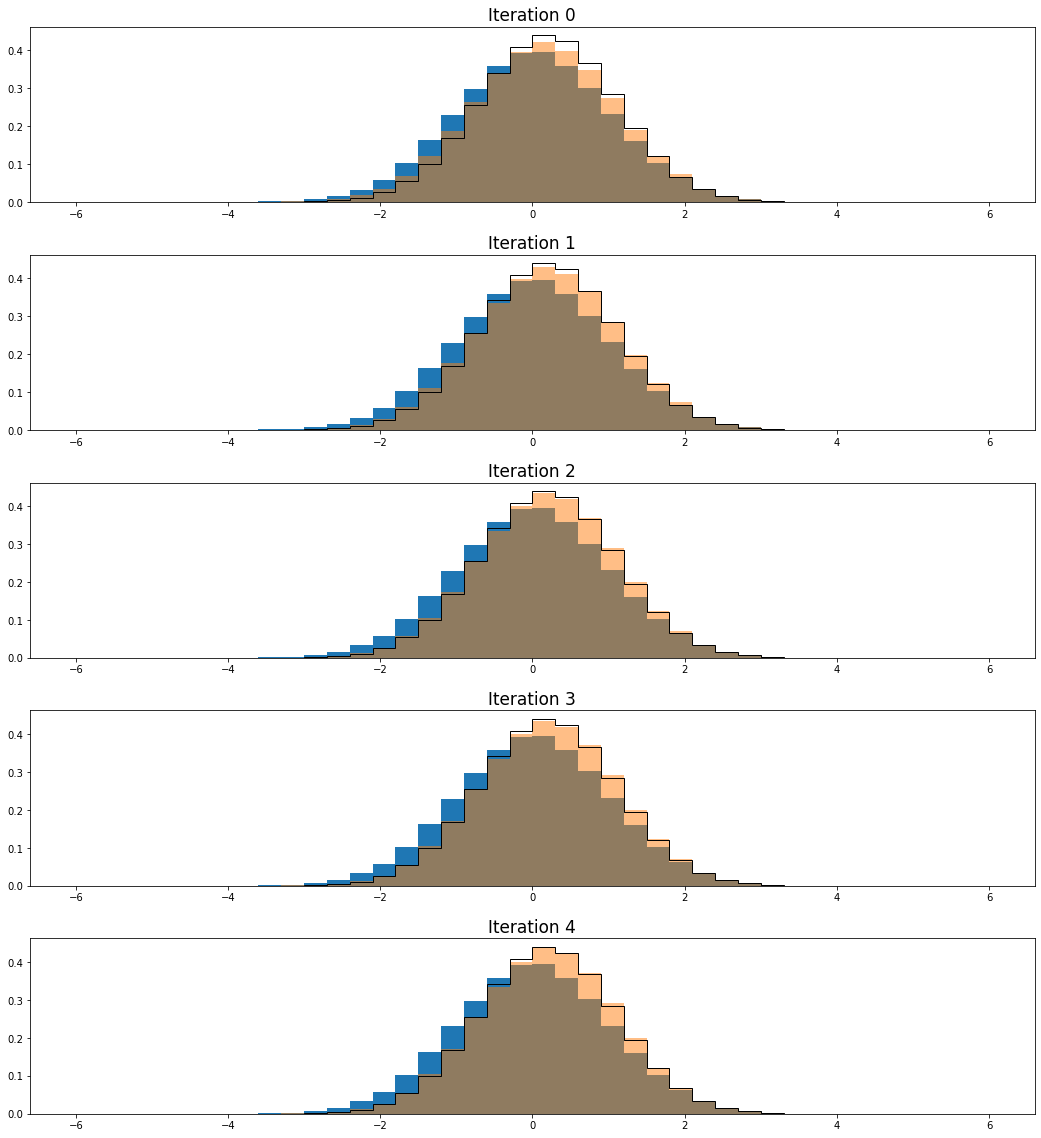

In [61]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [62]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

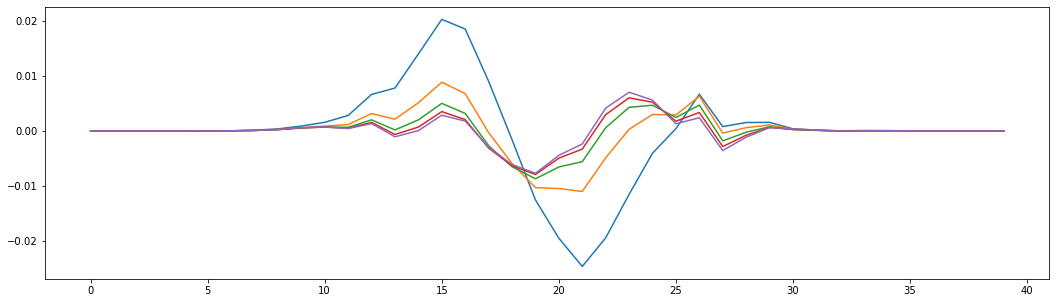

In [63]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

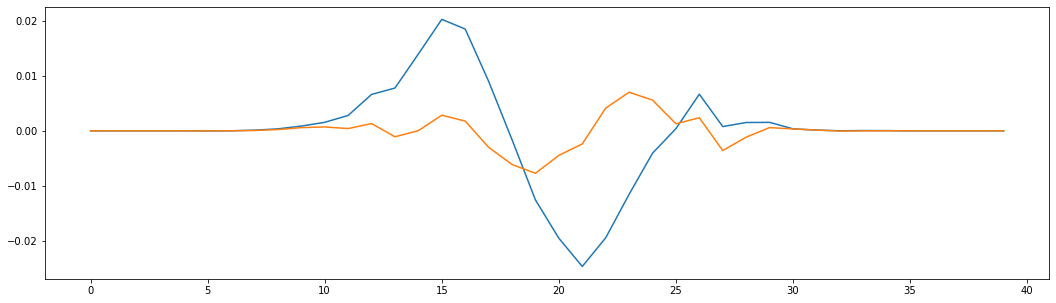

In [64]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

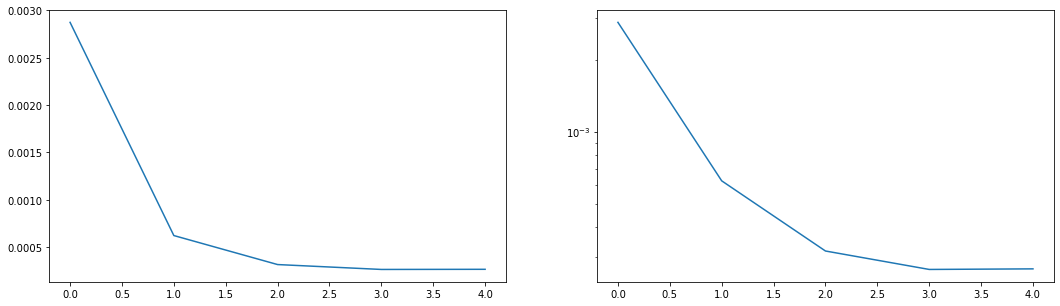

In [65]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

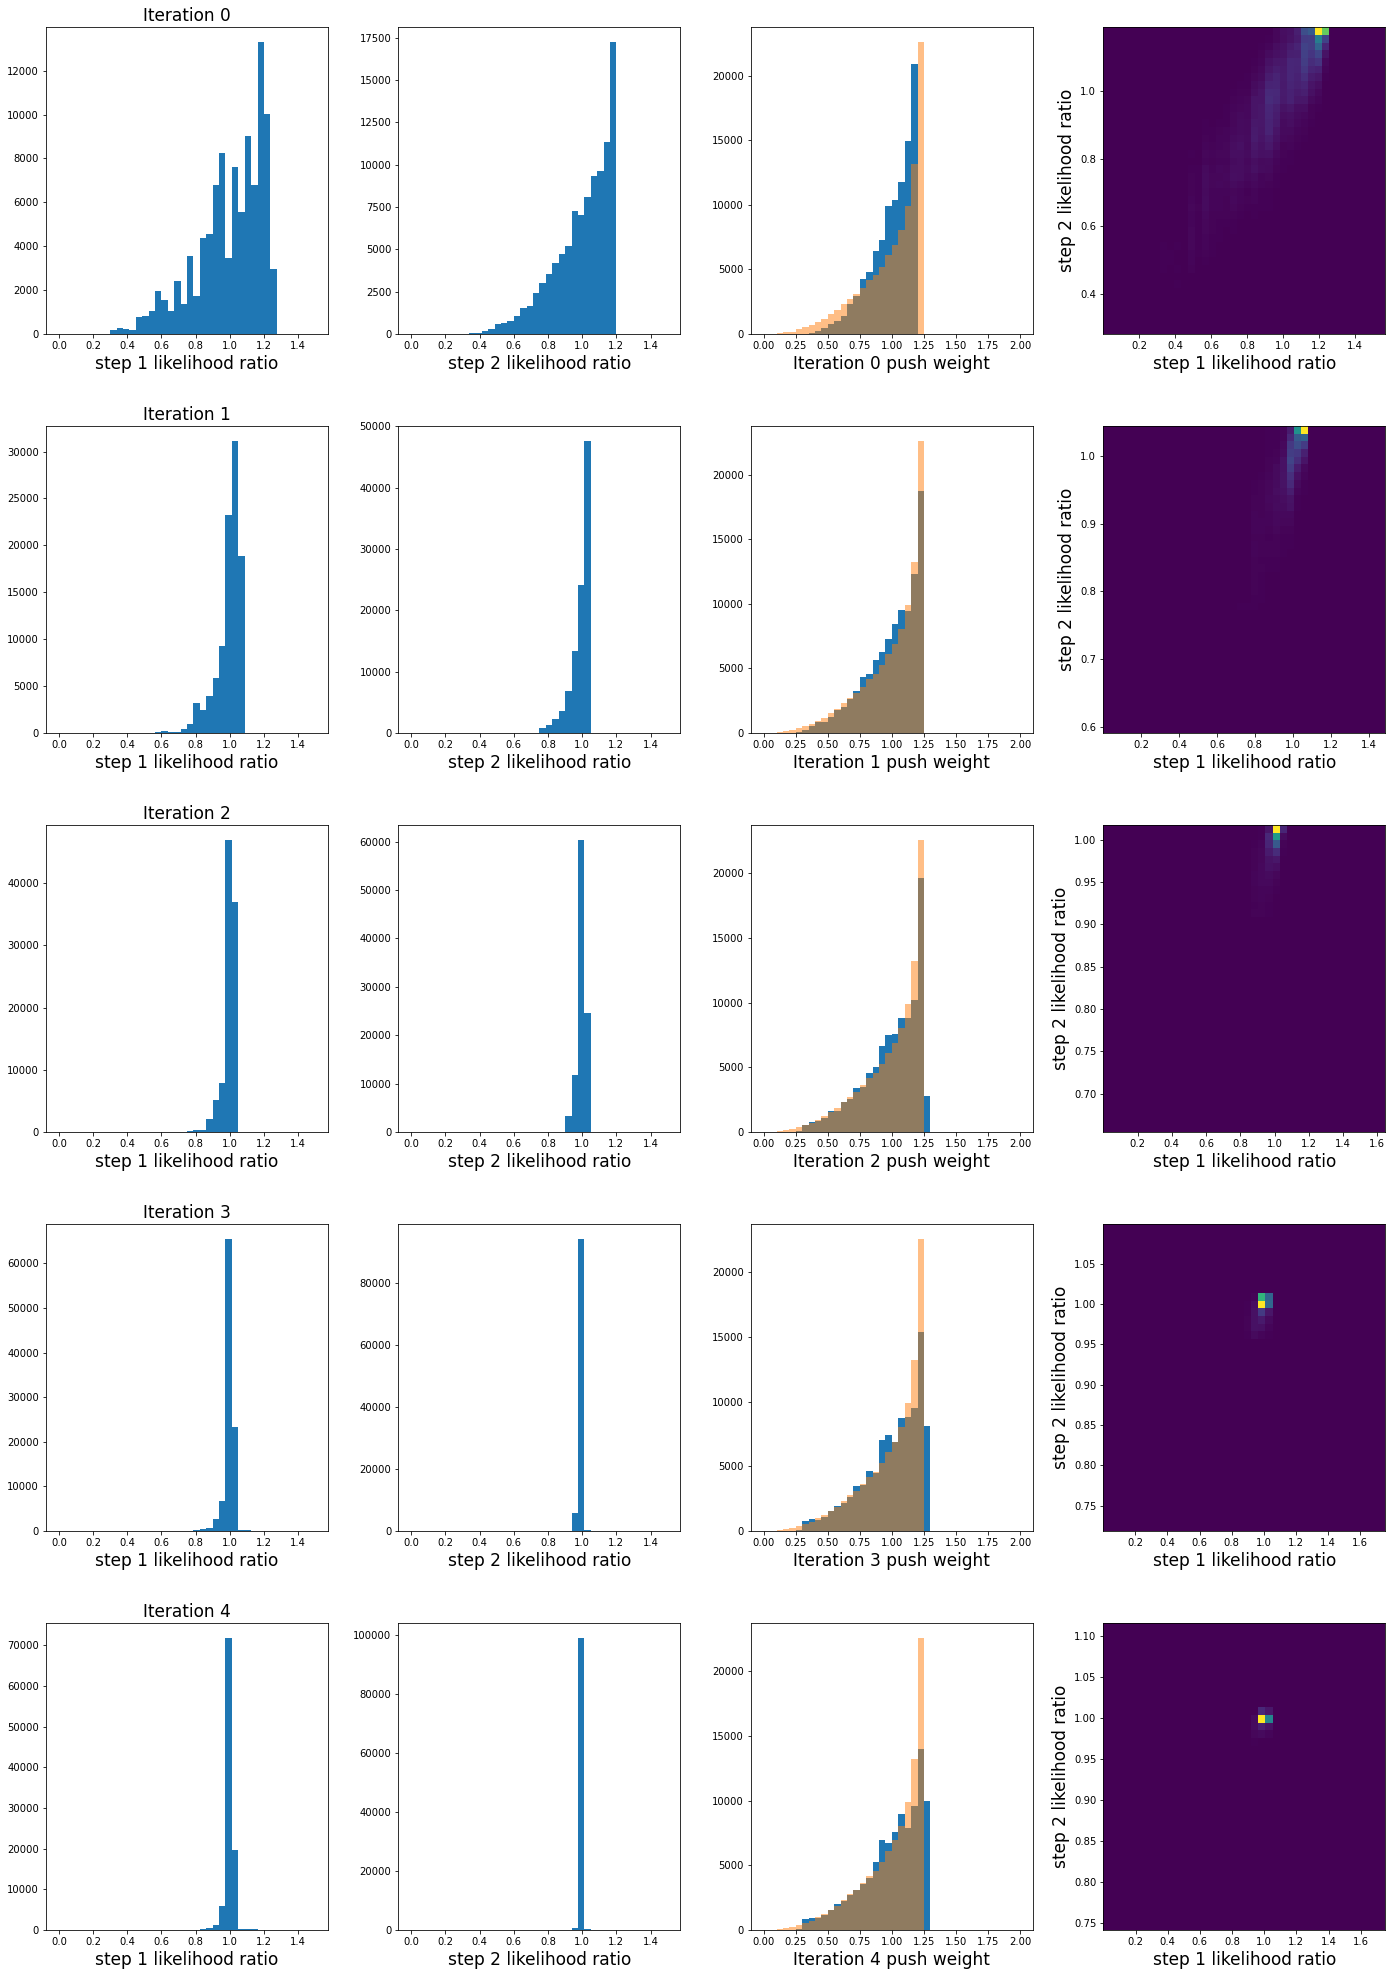

In [66]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

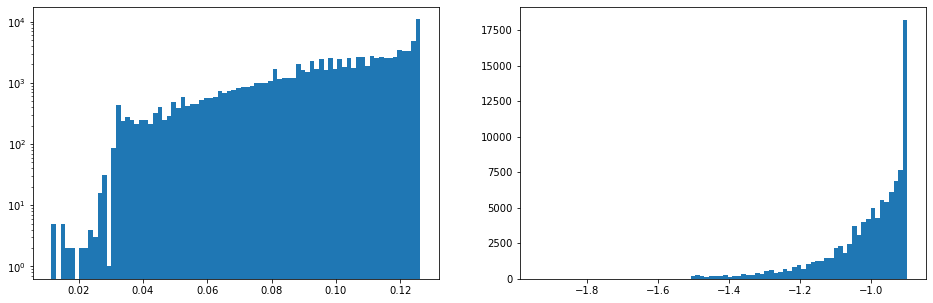

In [67]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

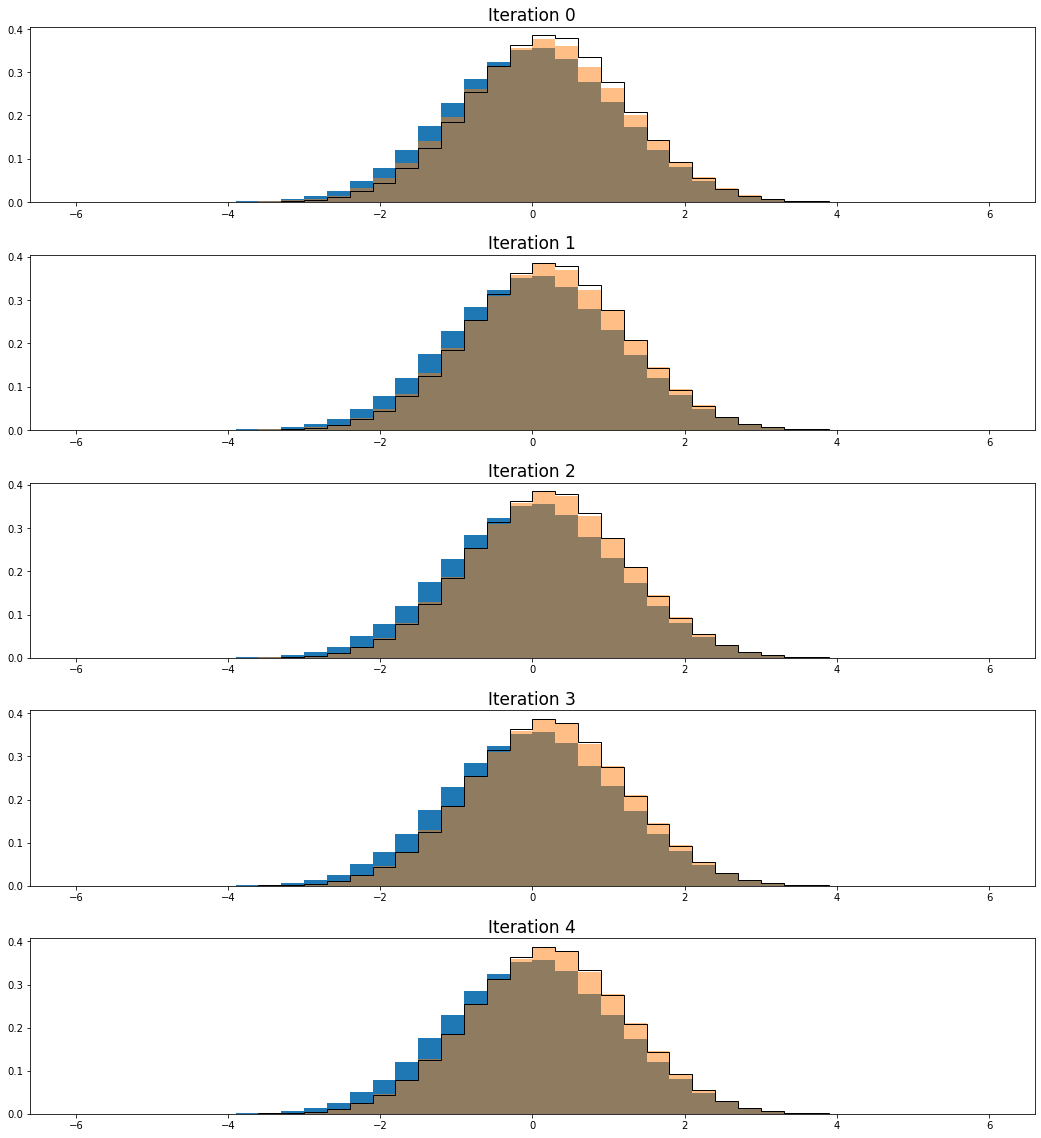

In [68]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [69]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

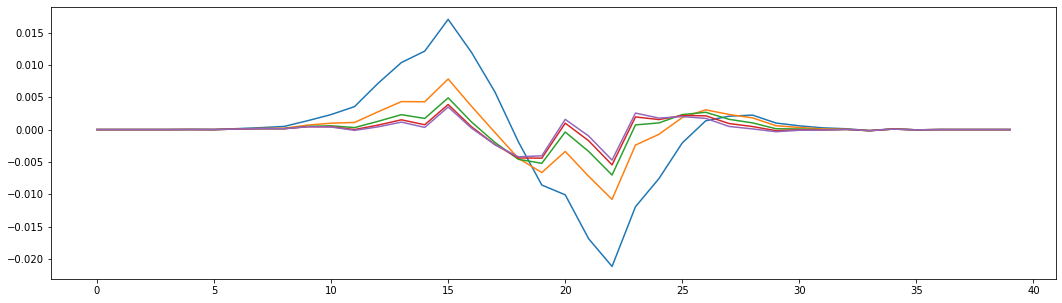

In [70]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

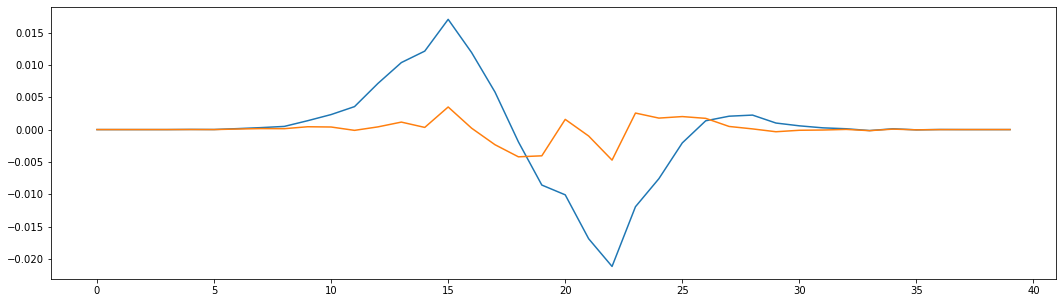

In [71]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

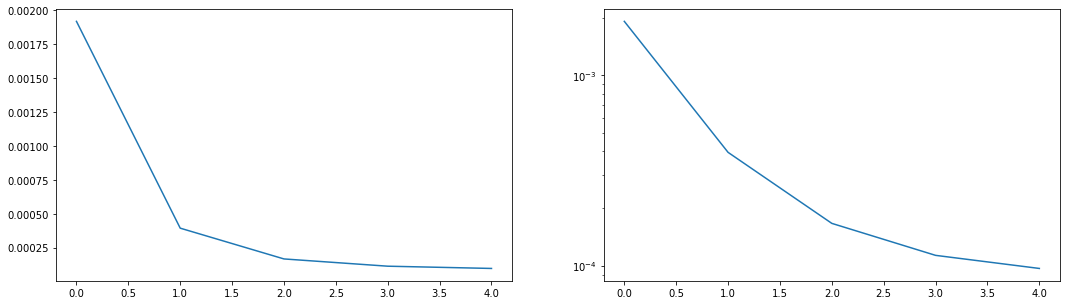

In [72]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [73]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.000  rms 0.196      step 2 mean  1.000  rms 0.165
  iter  1 : step 1 mean  0.991  rms 0.074      step 2 mean  0.991  rms 0.056
  iter  2 : step 1 mean  0.996  rms 0.040      step 2 mean  0.996  rms 0.022
  iter  3 : step 1 mean  0.999  rms 0.032      step 2 mean  0.999  rms 0.010
  iter  4 : step 1 mean  0.999  rms 0.031      step 2 mean  0.999  rms 0.006


<function matplotlib.pyplot.show(close=None, block=None)>

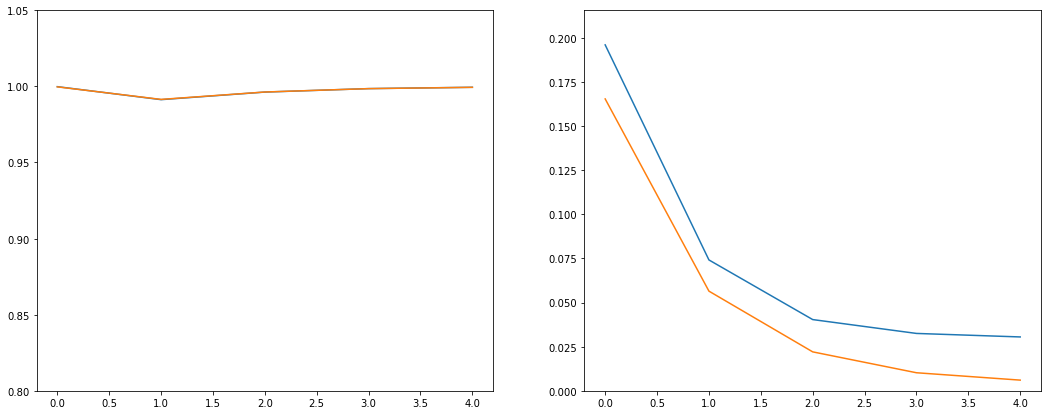

In [74]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

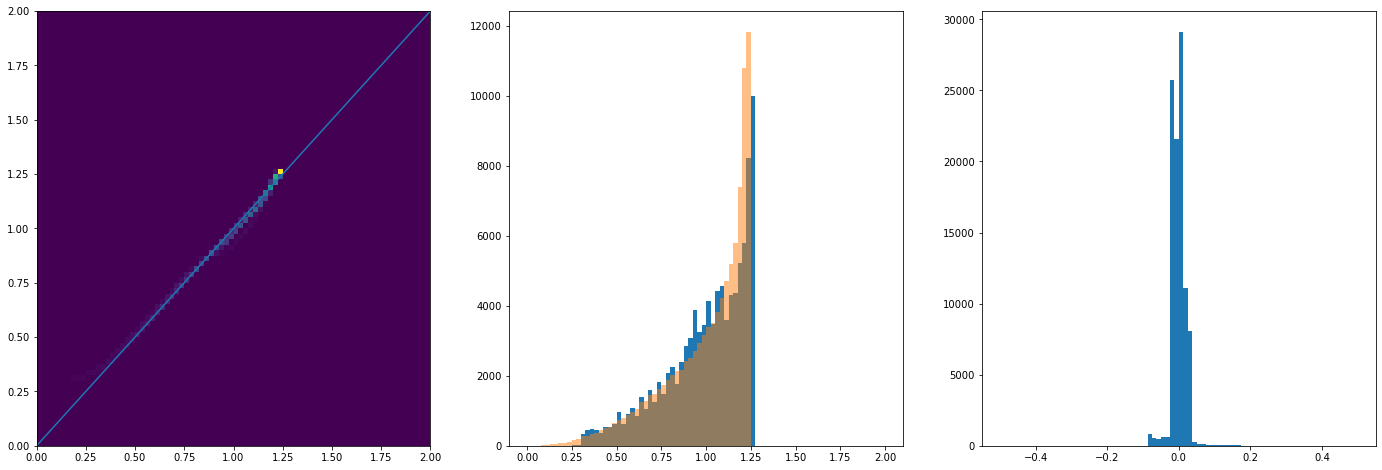

In [75]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [76]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.02281




In [77]:
of_prob = of_return_dict['weights'] / (1. + of_return_dict['weights'] )

In [78]:
def profile2d( axis, xvals, yvals, hbins, hrange, drawhist=True, drawline=False ) :
    
    hist_data = axis.hist2d( xvals, yvals, bins=hbins, range=hrange)
    
    if not drawhist :
        axis.cla()

    nybins = len(hist_data[0][0])
    print("number of y bins: %d" % nybins)

    nxbins = len(hist_data[0])
    print("number of x bins: %d" % nxbins)



    x_vals = np.zeros( nxbins )
    avey_vals = np.zeros( nxbins )
    rmsy_vals = np.zeros( nxbins )

    for xbi in range( nxbins ) :

        wsum = 0
        ywsum = 0
        yywsum = 0

        xval = 0.5 * ( hist_data[1][xbi] + hist_data[1][xbi+1] )
        #print(" xbin %d has center at %6.3f" % ( xbin_ind, xval ))

        for ybi in range( nybins ) :  
            yval = 0.5 * ( hist_data[2][ybi] + hist_data[2][ybi+1] )
            bin_content = hist_data[0][xbi][ybi]
            wsum = wsum + bin_content
            ywsum = ywsum + yval * bin_content
            yywsum = yywsum + yval * yval * bin_content
            #print("  %3d : y = %6.3f  bin content = %7d" % (bi, yval, bin_content))

        ave_y = ywsum / wsum
        ave_yy = yywsum / wsum
        rms_y = ave_yy - ave_y * ave_y
        #print(" Ave y = %.3f, RMS y = %.3f" % ( ave_y, rms_y) )

        x_vals[xbi] = xval
        avey_vals[xbi] = ave_y
        rmsy_vals[xbi] = rms_y


    #for xbi in range( nxbins ) :
        #print("  %4d :  x = %7.3f   ave y = %7.3f  rms y = %7.3f" % ( xbi, x_vals[xbi], avey_vals[xbi], rmsy_vals[xbi]))

    if drawline :
        axis.plot( (hist_data[1][0], hist_data[1][-1]), (0,0) )  
    
    axis.errorbar( x_vals, avey_vals, yerr=rmsy_vals, fmt='-', linewidth=5)

    
    plt.show
    

In [79]:
def prob_from_hists( points_a, points_b, weights_a, weights_b, hnbins, hxmin, hxmax ) :
    
    hbw = (hxmax-hxmin)/hnbins
    
    #-- calculate bin indices
    bin_indices_a = np.array( (points_a - hxmin)/hbw, dtype=int )
    bin_indices_b = np.array( (points_b - hxmin)/hbw, dtype=int )
    
    
    hist_binsum_a = np.zeros( hnbins )
    hist_binsum_b = np.zeros( hnbins )
    
    hist_err_a = np.zeros( hnbins )
    hist_err_b = np.zeros( hnbins )
    
    hist_ratio = np.zeros( hnbins )
    hist_ratio_err = np.zeros( hnbins )
    
    sample_wsum_a = np.sum(weights_a)
    sample_wsum_b = np.sum(weights_b)

    
    for bi in range( hnbins ) :
        hist_binsum_a[bi] = np.sum( weights_a[ bin_indices_a == bi ] ) / sample_wsum_a
        hist_binsum_b[bi] = np.sum( weights_b[ bin_indices_b == bi ] ) / sample_wsum_b
        hist_err_a[bi] = np.sqrt( np.sum( np.square( weights_a[ bin_indices_a == bi ] ) ) ) / sample_wsum_a
        hist_err_b[bi] = np.sqrt( np.sum( np.square( weights_b[ bin_indices_b == bi ] ) ) ) / sample_wsum_b
        if hist_binsum_b[bi] > 0 :
            hist_ratio[bi] = hist_binsum_b[bi] / (hist_binsum_a[bi] + hist_binsum_b[bi])
            if hist_binsum_a[bi] > 0 :
                hist_ratio_err[bi] = np.sqrt(
                    np.square( (hist_binsum_b[bi]/np.square(hist_binsum_b[bi]+hist_binsum_a[bi])) * hist_err_a[bi] ) +
                    np.square( (hist_binsum_a[bi]/np.square(hist_binsum_b[bi]+hist_binsum_a[bi])) * hist_err_b[bi] )
                )
        
    return_dict = {}
    return_dict['hist_binsum_a'] = hist_binsum_a
    return_dict['hist_binsum_b'] = hist_binsum_b
    return_dict['hist_err_a'] = hist_err_a
    return_dict['hist_err_b'] = hist_err_b
    return_dict['hist_ratio'] = hist_ratio
    return_dict['hist_ratio_err'] = hist_ratio_err
    
    return return_dict
    

number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_396791/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_396791/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_396791/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_396791/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_396791/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_396791/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_396791/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_396791/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_396791/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_396791/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


<function matplotlib.pyplot.show(close=None, block=None)>

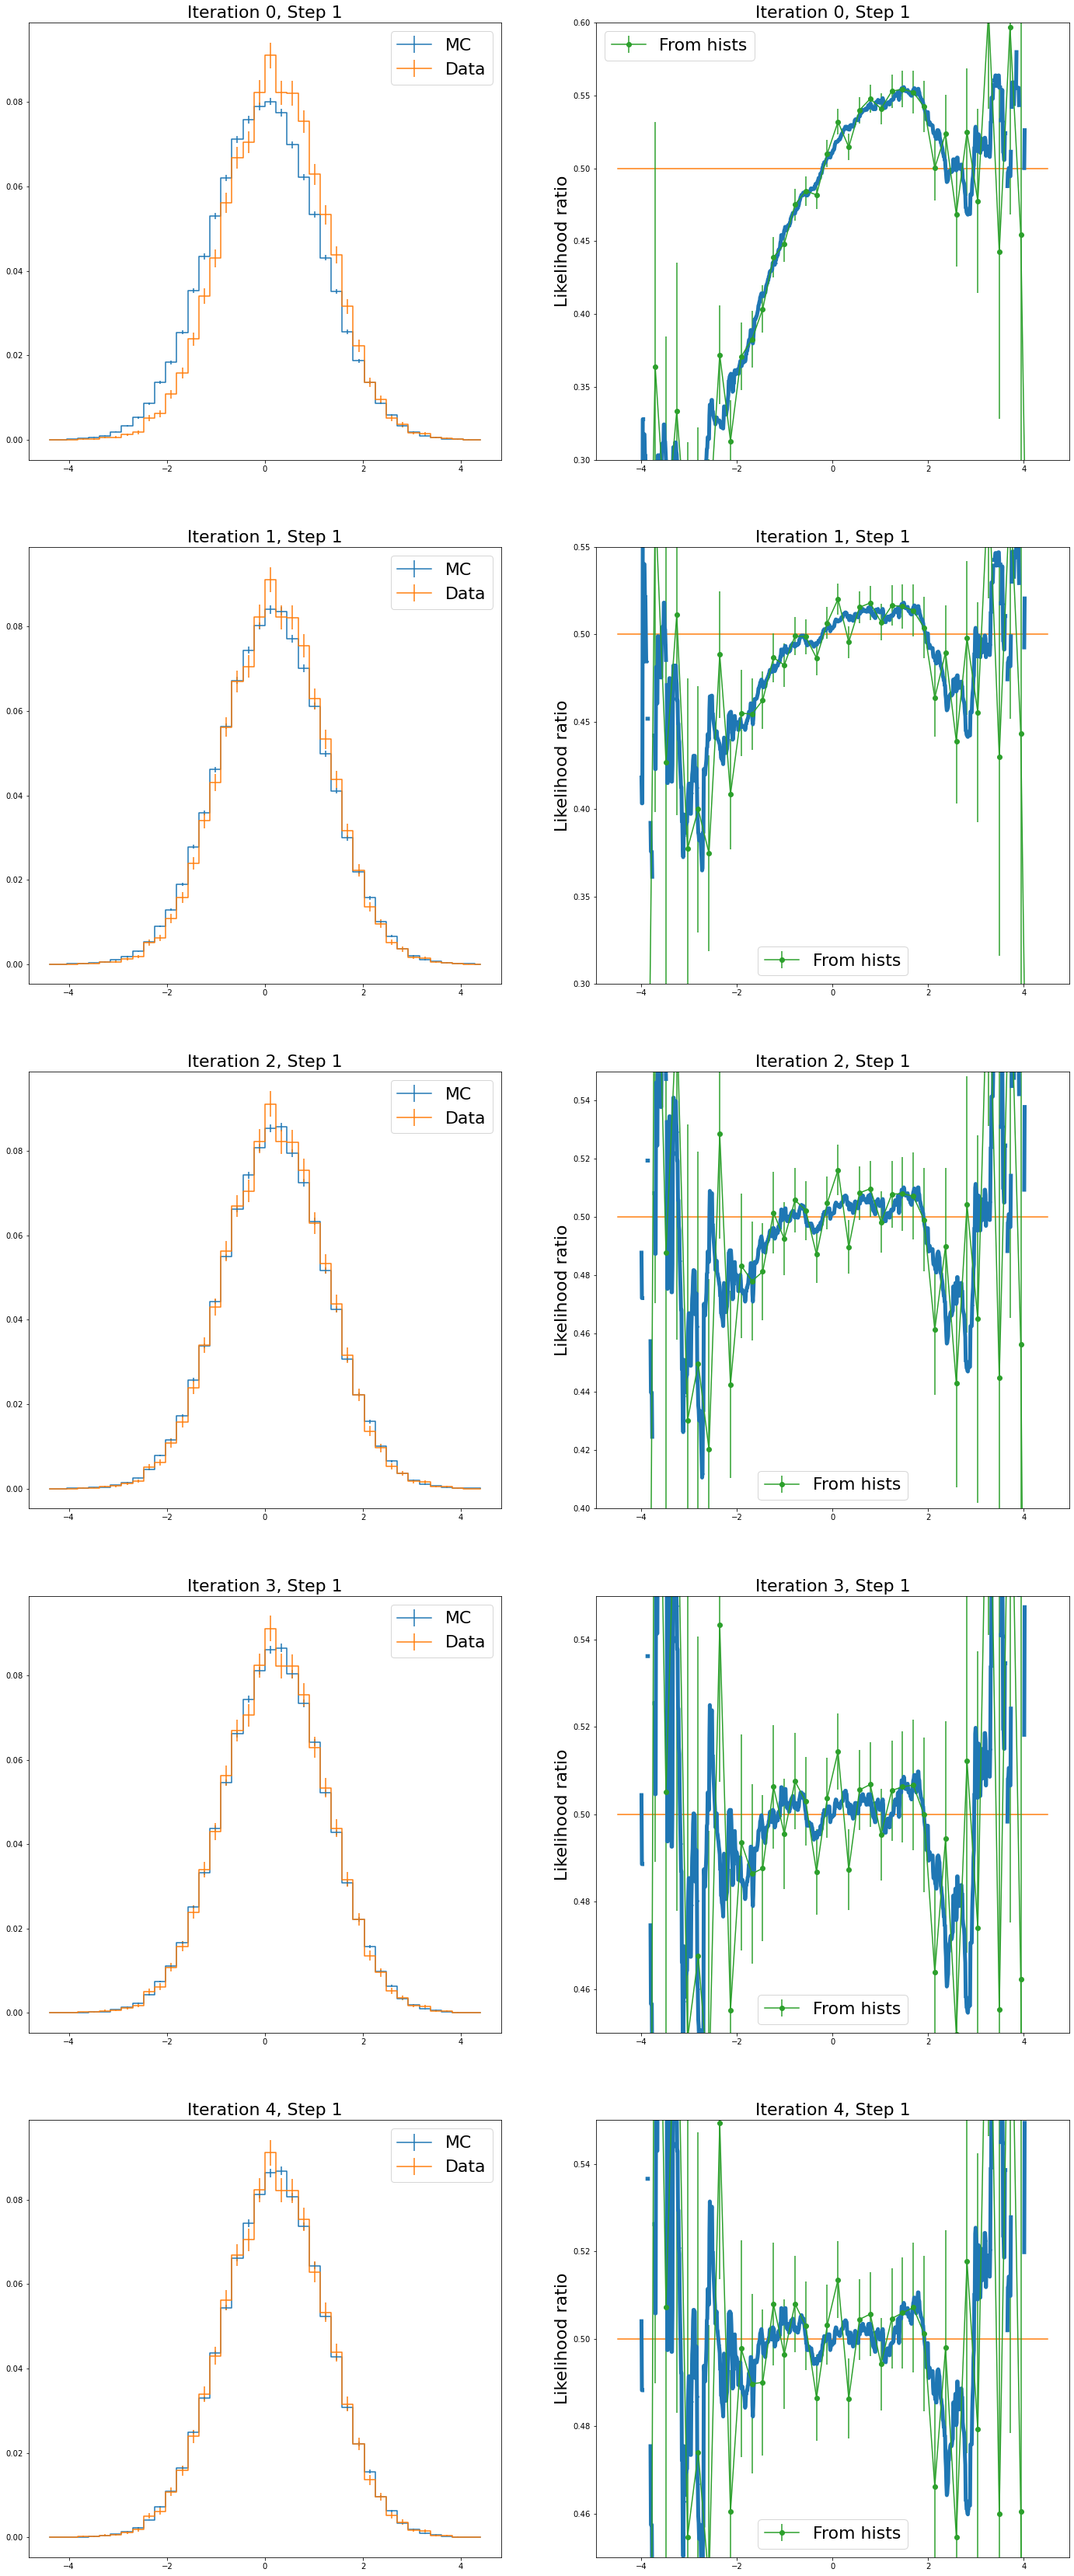

In [80]:

hxmin = -4.5
hxmax = 4.5


hnbins = 40

ymin = 0.2
ymax = 0.6

hbw = (hxmax-hxmin) / hnbins

xvals = np.zeros( hnbins )
for bi in range( hnbins ) :
    xvals[bi] = hxmin + (0.5 + bi)*hbw

nnbins = 1000

plotymin=[0.30, 0.30, 0.40, 0.45, 0.45]
plotymax=[0.60, 0.55, 0.55, 0.55, 0.55]


#plotymin=[0.30, 0.45, 0.49, 0.49, 0.49]
#plotymax=[0.60, 0.55, 0.51, 0.51, 0.51]



fig,ax = plt.subplots( of_niter, 2, figsize=(2*12,of_niter*12))


for ofi in range( of_niter ) :
    
    weights_ones_b = np.ones( len(true_det_pts[:,0]) )

    if ofi==0 :        
        weights_a = np.ones( len(train_det_pts[:,0]) )        
    else :
        weights_a = of_return_dict['push_weights'][ofi-1]

    rd = prob_from_hists( train_det_pts[:,0], 
                             true_det_pts[:,0], 
                             weights_a, 
                             weights_ones_b, 
                             hnbins, hxmin, hxmax )

    axi = ax[ofi][0]
    axi.errorbar( xvals, rd['hist_binsum_a'], rd['hist_err_a'], drawstyle='steps-mid', label='MC')
    axi.errorbar( xvals, rd['hist_binsum_b'], rd['hist_err_b'], drawstyle='steps-mid', label='Data')
    axi.legend( fontsize=22 )
    axi.set_title('Iteration %d, Step 1' % ofi, fontsize=22 )
        
    axi = ax[ofi][1]
    profile2d( axi, train_det_pts[:,0], of_prob[ofi,0,:], 
          hbins=[nnbins,nnbins], hrange=([hxmin,hxmax],[ymin,ymax]), drawhist=False, drawline=False ) 
    axi.plot([hxmin,hxmax],[0.5,0.5])
    axi.errorbar(xvals,rd['hist_ratio'],rd['hist_ratio_err'], marker='o', linestyle='-', label='From hists')
    axi.legend( fontsize=22 )
    axi.set_ylabel('Likelihood ratio', fontsize=22 )
    
    axi.set_ylim( plotymin[ofi], plotymax[ofi] )
    axi.set_title('Iteration %d, Step 1' % ofi, fontsize=22 )
        

        
        
plt.show

number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_396791/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_396791/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_396791/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_396791/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_396791/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_396791/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_396791/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_396791/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


number of y bins: 1000
number of x bins: 1000


/tmp/ipykernel_396791/2115069057.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_396791/2115069057.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


<function matplotlib.pyplot.show(close=None, block=None)>

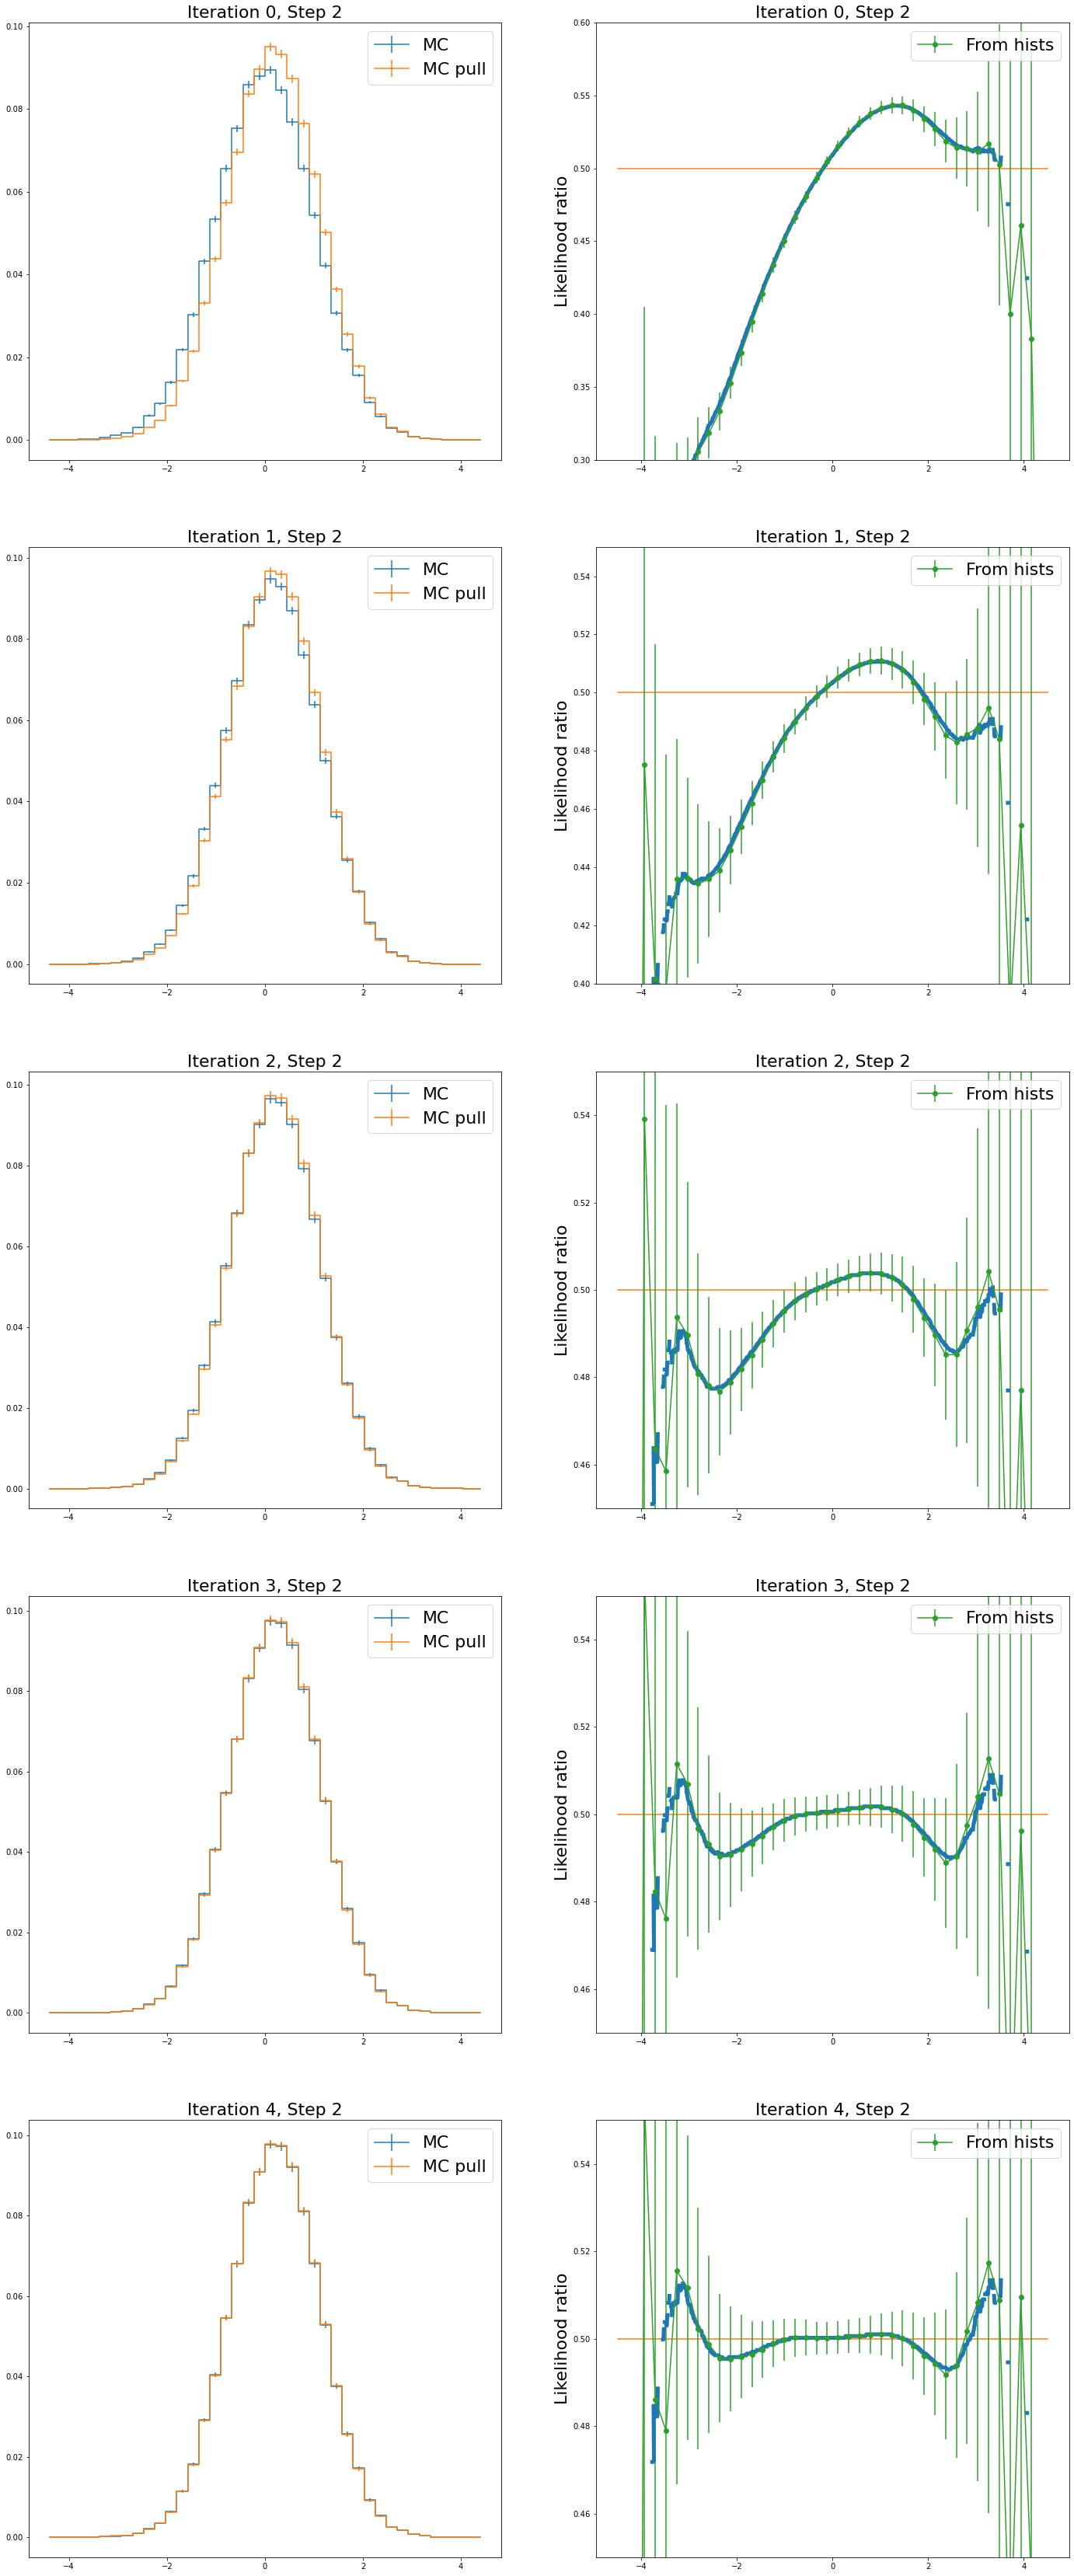

In [81]:

hxmin = -4.5
hxmax = 4.5


hnbins = 40



hbw = (hxmax-hxmin) / hnbins

xvals = np.zeros( hnbins )
for bi in range( hnbins ) :
    xvals[bi] = hxmin + (0.5 + bi)*hbw

nnbins = 1000

plotymin=[0.30, 0.40, 0.45, 0.45, 0.45]
plotymax=[0.60, 0.55, 0.55, 0.55, 0.55]

#plotymin=[0.30, 0.45, 0.49, 0.49, 0.49]
#plotymax=[0.60, 0.55, 0.51, 0.51, 0.51]





fig,ax = plt.subplots( of_niter, 2, figsize=(2*12,of_niter*12))


for ofi in range( of_niter ) :
    
    previous_push_weights = np.ones( len(train_pts[:,0]))
    if ofi > 0 :
        previous_push_weights = of_return_dict['push_weights'][ofi-1]
                
    pull_weights = previous_push_weights * of_return_dict['weights'][ofi,0,:]
    


    rd = prob_from_hists( train_pts[:,0], 
                             train_pts[:,0], 
                             previous_push_weights, 
                             pull_weights, 
                             hnbins, hxmin, hxmax )

    axi = ax[ofi][0]
    axi.errorbar( xvals, rd['hist_binsum_a'], rd['hist_err_a'], drawstyle='steps-mid', label='MC')
    axi.errorbar( xvals, rd['hist_binsum_b'], rd['hist_err_b'], drawstyle='steps-mid', label='MC pull')
    axi.legend( fontsize=22 )
    axi.set_title('Iteration %d, Step 2' % ofi, fontsize=22 )
        
    axi = ax[ofi][1]
    profile2d( axi, train_pts[:,0], of_prob[ofi,1,:], 
          hbins=[nnbins,nnbins], hrange=([hxmin,hxmax],[ymin,ymax]), drawhist=False, drawline=False ) 
    axi.plot([hxmin,hxmax],[0.5,0.5])
    axi.errorbar(xvals,rd['hist_ratio'],rd['hist_ratio_err'], marker='o', linestyle='-', label='From hists')
    axi.legend( fontsize=22 )
    axi.set_ylabel('Likelihood ratio', fontsize=22 )
    
    axi.set_ylim( plotymin[ofi], plotymax[ofi] )
    axi.set_title('Iteration %d, Step 2' % ofi, fontsize=22 )
        

        
        
plt.show